<a href="https://colab.research.google.com/github/SydanJainen/4EU-DeepLearningCourse/blob/main/Assignments/AssignementCNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assignments

### We are given a dataset containing 510 images which are categorized according two main characteristics/properties: “C1” and “C2”. The following inputs are available:
* #### `input image', a 110 × 110 × 3 real-valued tensor. The last dimension denotes the number of input channels; the images belong to different combinations of the two properties C1 and C2. For C1 and C2 we have 5 and 6 possible values, respectively;  among the 30 possible couples (C1,C2), we have images for only 24 of them. We have around 20 samples (little more or less) for each of the available couples;  values in each tensor entry are integers in [0, 255];
* #### C1, string, the value for the C1 property. 5 possible values;
* #### C2, string, the value for the C2 property. 6 possible values.

### Design a deep neural network model to predict the class of an image, given by the couple (C1,C2).

### Provide a sketch of each of the following points, then implement your solution.
1. MODEL: Which architecture do you consider the most appropriate for this task, and why;
2. INPUT:
* After a potential preprocessing step, which is the input of the model, and
how is it represented;
3. OUTPUT: How would you design the output layer and why;
4. LOSS: Which loss function would you use to train your model and why;
5. MODEL CONFIGURATION:
 Model composition (composition of layers, regardless their number,
or their dimension, which can be object of tuning)
6. MODEL EVALUATION: How would you assess (in which setting) the
generalization capabilities of the model on unseen data?


In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

## go to your datapath
%cd /content/drive/MyDrive/INSEGNAMENTI/4EU+/

# Here you should see the desired files
%ls

Mounted at /content/drive
/content/drive/MyDrive/INSEGNAMENTI/4EU+
input.pkl


In [2]:
import pickle as pk
# Open the pickle data
with open('input.pkl', 'rb') as f:
  data = pk.load(f)

images = data['imgs']
C1 = data['C1']
C2 = data['C2']
print(f"length image:{len(images)}")
print(f"length C1:{len(C1)}")
print(f"length C2:{len(C2)}")

length image:510
length C1:510
length C2:510


In [3]:
#import
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import torchvision
from torchvision import transforms


import numpy as np
import matplotlib.pyplot as plt
from torchvision.transforms import ToTensor, Normalize, Compose
from torch.utils.data import random_split

In [4]:
transofm = Compose([ToTensor(),
                        Normalize((0,), (1,))])
tensor_images = []
for i in images :
  tensor_images.append(transofm(i))

In [5]:
for a in np.unique(C1):
  print(a)

dress
pants
shirt
shoes
shorts


In [6]:
for a in np.unique(C2):
  print(a)

black
blue
brown
green
red
white


In [7]:
main_dataset = zip(tensor_images, C1, C2)

label_combinations = {}
for i, (c1, c2) in enumerate(zip(C1, C2)):
    label_combinations[i] = f"{c1} {c2}"

unique_labels = set(label_combinations.values())
label_to_index = {label: i for i, label in enumerate(unique_labels)}
print(label_to_index)

enumerated_dataset = []
for i, (tensor_images, c1, c2) in enumerate(zip(tensor_images, C1, C2)):
  label_combination = f"{c1} {c2}"
  label_index = label_to_index[label_combination]
  enumerated_dataset.append((tensor_images, label_index))

print(len(enumerated_dataset))

{'shoes black': 0, 'shoes brown': 1, 'dress blue': 2, 'dress white': 3, 'pants blue': 4, 'shorts blue': 5, 'pants green': 6, 'shirt green': 7, 'pants red': 8, 'shorts white': 9, 'shorts black': 10, 'shorts brown': 11, 'pants black': 12, 'shirt blue': 13, 'shoes green': 14, 'pants white': 15, 'shoes red': 16, 'shorts green': 17, 'dress red': 18, 'shoes blue': 19, 'dress black': 20, 'pants brown': 21, 'shoes white': 22, 'shirt black': 23}
510


In [8]:
BATCH_SIZE = 30

train_size = int(0.7 * len(enumerated_dataset))
val_size = int(0.1 * len(enumerated_dataset))
test_size = len(enumerated_dataset) - train_size - val_size

train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(enumerated_dataset, [train_size, val_size, test_size])

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [9]:
def dimension(N,P,S,F) :
  return (int((N + (2*P) - F)/ S) + 1)

In [10]:
class CNN(nn.Module):
    def __init__(self, kernel_size, stride, padding, pooling_strategy, dropout_rate):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3,
                               out_channels=32,
                               kernel_size = kernel_size,
                               stride=stride,
                               padding=padding)
        dim1 = dimension(110, padding, stride, kernel_size)
        #print(dim1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size, stride, padding)
        dim2 = dimension(dim1, padding, stride, kernel_size)
        #print(dim2)
        if pooling_strategy == "mean" :
          self.pool2d = nn.AvgPool2d(kernel_size=2, stride=2)
        elif pooling_strategy == "max" :
          self.pool2d = nn.MaxPool2d(kernel_size=2, stride=2)
        else :
          raise Exception()
        dim3 = int(((dim2-2)/2 +1) * ((dim2-2)/2 +1) * 64) # 'same' = dim3
        #print(dim3)
        self.dropout1 = nn.Dropout(dropout_rate)
        self.fc1 = nn.Linear(dim3, 128)
        self.dropout2 = nn.Dropout(dropout_rate)
        self.fc2 = nn.Linear(128, 30)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = self.pool2d(x)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        output = F.log_softmax(x, dim=1)
        return output

kernel_size_list = [3, 4, 5]
stride = 1
padding = 0
pooling_strategy_list = ['mean', 'max']
dropout_rate_list = [0, 0.1, 0.25]

In [11]:
# Computing the accuracy of a test set
def evaluate(model, test_loader, error):
#model = mlpinplace=False
    correct = 0
    cur_loss = 0;

    for test_imgs, test_labels in test_loader:
        test_imgs, test_labels = test_imgs.cuda(), test_labels.cuda()
        output = model(test_imgs)
        loss = error(output, test_labels)
        cur_loss+=loss.item()
        predicted = torch.max(output,1)[1]
        correct += (predicted == test_labels).sum()
    return cur_loss/len(test_loader.dataset), correct/len(test_loader.dataset)



def fit(model, train_loader, error, test_loader, epochs):
    optimizer = torch.optim.Adam(model.parameters(),lr=0.0001)#,lr=0.001, betas=(0.9,0.999))
    model.train()
    train_losses = []
    test_losses = []

    for epoch in range(epochs):
        cur_loss = 0;
        correct = 0
        for X_batch, y_batch in train_loader:
            if dev == "cpu":
              X_batch, y_batch = X_batch.cpu(), y_batch.cpu()
            else:
              X_batch, y_batch = X_batch.cuda(), y_batch.cuda()
            optimizer.zero_grad()
            output = model(X_batch)
            loss = error(output, y_batch)
            cur_loss+= loss.item()
            loss.backward()
            optimizer.step()

        train_losses.append(cur_loss/len(train_loader.dataset))

        test_loss, _ = evaluate(model, test_loader, error)
        test_losses.append(test_loss)
        print(f'Epoch : {epoch},  train loss:{train_losses[-1]}, test loss:{test_losses[-1]}')

    return train_losses, test_losses

In [12]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

In [13]:

error = nn.CrossEntropyLoss()
## We use validation data to select the best hyperparameters
## Fewer epochs to speed-up
epochs = 5
### initializing best config
best_accval = 0
best_ks = -1
best_pool = ""
best_dr = -1
for kernel_size in kernel_size_list:
  for pooling_strategy in pooling_strategy_list:
    for dropout_rate in dropout_rate_list:

      model = CNN(kernel_size, stride, padding, pooling_strategy, dropout_rate)
      print(f"kernel size:{kernel_size}, pooling:{pooling_strategy},\
                  dropout rate:{dropout_rate}")

      it = iter(train_loader)
      X_batch, y_batch = next(it)

      if torch.cuda.is_available():
        dev = "cuda:0"
        model.cuda()
      else:
        dev = "cpu"
        model.cpu()
      device = torch.device(dev)


      train_losses, test_losses = fit(model,train_loader, error, val_loader, epochs)

      loss, acc = evaluate(model, train_loader, error)
      print(f"\tTrain Accuracy:{acc}, Train loss:{loss}")

      loss, acc = evaluate(model, val_loader, error)
      print(f"\tValidation Accuracy:{acc}, Validation loss:{loss}")
      if acc > best_accval:
        best_accval = acc
        best_ks = kernel_size
        best_pool = pooling_strategy
        best_dr = dropout_rate

      print("\n\n")

kernel size:3, pooling:mean,                  dropout rate:0
Epoch : 0,  train loss:0.11063179248521308, test loss:0.12385350582646389
Epoch : 1,  train loss:0.09762561221082672, test loss:0.1128545695660161
Epoch : 2,  train loss:0.08437686741185121, test loss:0.10044198410183776
Epoch : 3,  train loss:0.07295190019099987, test loss:0.09024972541659486
Epoch : 4,  train loss:0.06260450681050618, test loss:0.0833359115263995
	Train Accuracy:0.5630252361297607, Train loss:0.05527310878956685
	Validation Accuracy:0.4313725531101227, Validation loss:0.0833359115263995



kernel size:3, pooling:mean,                  dropout rate:0.1
Epoch : 0,  train loss:0.11408271976545745, test loss:0.12996288841845943
Epoch : 1,  train loss:0.10627305340700123, test loss:0.12312807756311753
Epoch : 2,  train loss:0.09888509875919972, test loss:0.11326481314266429
Epoch : 3,  train loss:0.09046808811796814, test loss:0.10024400785857555
Epoch : 4,  train loss:0.0822277690182213, test loss:0.09249614266

best configuration: kernel size:5, pooling:max,                  dropuout rate:0
Epoch : 0,  train loss:0.1121071914330918, test loss:0.12410099132388246
Epoch : 1,  train loss:0.09804792364104455, test loss:0.11082649230957031
Epoch : 2,  train loss:0.0836413834943157, test loss:0.09610849034552481
Epoch : 3,  train loss:0.06975508871532622, test loss:0.08898554362502753
Epoch : 4,  train loss:0.05529015137701809, test loss:0.07532300551732381
Epoch : 5,  train loss:0.044211095621605884, test loss:0.07631655417236627
Epoch : 6,  train loss:0.03840613782572813, test loss:0.0699462797127518
Epoch : 7,  train loss:0.031828557910705484, test loss:0.06568724384494856
Epoch : 8,  train loss:0.0235647832980009, test loss:0.058634387511833044
Epoch : 9,  train loss:0.018323839378624068, test loss:0.06022073357712989
Epoch : 10,  train loss:0.01535351294763282, test loss:0.056714441262039485
Epoch : 11,  train loss:0.011601141479168953, test loss:0.06125546086068247
Epoch : 12,  train loss:0.0

<Figure size 640x480 with 0 Axes>

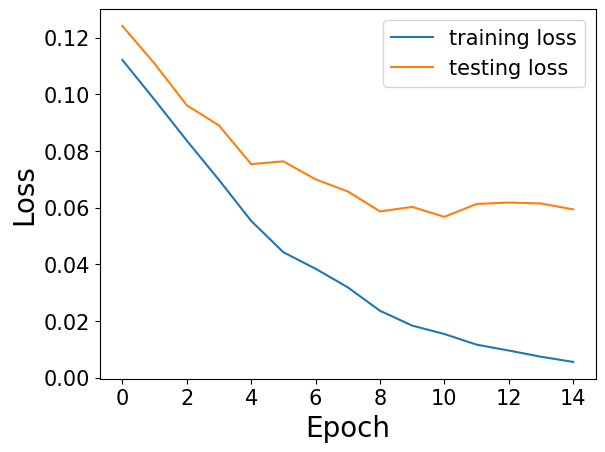

<Figure size 640x480 with 0 Axes>

In [15]:
print(f"best configuration: kernel size:{best_ks}, pooling:{best_pool},\
                  dropuout rate:{best_dr}")
# Pick the best model and verify its performance on the test set
model = CNN(best_ks, stride, padding, best_pool, best_dr)

#it = iter(train_dataloader)
#X_batch, y_batch = next(it)

if torch.cuda.is_available():
  dev = "cuda:0"
else:
  dev = "cpu"
device = torch.device(dev)

model.cuda()
## we set again more epochs for the final training.
## Note that here we could integrate the validaiton data in the training set
epochs = 15
train_losses, test_losses = fit(model,train_loader, error, test_loader, epochs)

loss, acc = evaluate(model, test_loader, error)
print(f"Test Accuracy:{acc}, Test loss:{loss}")

plt.plot(train_losses,label="training loss")
plt.plot(test_losses,label="testing loss")
plt.legend(fontsize=15)
plt.xlabel('Epoch', fontsize=20)
plt.ylabel('Loss', fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.figure()

In [16]:
# validate and test

loss, acc = evaluate(model, train_loader, error)
print(f"Train Accuracy:{acc}, Train loss:{loss}")

loss, acc = evaluate(model, test_loader, error)
print(f"Test Accuracy:{acc}, Test loss:{loss}")

loss, acc = evaluate(model, val_loader, error)
print(f"Validation Accuracy:{acc}, Validation loss:{loss}")

Train Accuracy:0.9747899174690247, Train loss:0.005907506188925575
Test Accuracy:0.5784313678741455, Test loss:0.059336463610331215
Validation Accuracy:0.4901961088180542, Validation loss:0.06432717921687107
